In [2]:
import os, sys
if 'src' not in os.getcwd():
    os.chdir(f"{os.getcwd()}/src/data")
if 'data' not in os.getcwd():
    os.chdir(f"{os.getcwd()}/data")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
from collections import Counter

In [3]:
ism_file = 'ISM_df_with_correction.csv'
ism_df = pd.read_csv(ism_file)
ism_df.columns

Index(['gisaid_epi_isl', 'date', 'continent', 'division', 'location',
       'continent_exposure', 'division_exposure', 'segment', 'length', 'host',
       'age', 'sex', 'pangolin_lineage', 'GISAID_clade', 'originating_lab',
       'submitting_lab', 'authors', 'url', 'paper_url', 'date_submitted',
       'country/region', 'country/region_exposure', 'ISM'],
      dtype='object')

In [4]:
# Fix date
ism_df['date'] = pd.to_datetime(ism_df['date'], unit='D') - pd.Timedelta(25569, unit='D')
ism_df['date_submitted'] = pd.to_datetime(ism_df['date_submitted'], unit='D') - pd.Timedelta(25569, unit='D') 

In [5]:
ism_df

,gisaid_epi_isl,date,continent,division,location,continent_exposure,division_exposure,segment,length,host,...,GISAID_clade,originating_lab,submitting_lab,authors,url,paper_url,date_submitted,country/region,country/region_exposure,ISM
0,EPI_ISL_402124,2019-12-30,Asia,Hubei,Wuhan,Asia,Hubei,genome,29891,Human,...,L,Wuhan Jinyintan Hospital,"Wuhan Institute of Virology, Chinese Academy o...",Peng Zhou et al,https://www.gisaid.org,?,2020-01-11,Mainland China,Mainland China,CCAACCTCGGCCCGCACCCTAGGACGGCTCGGG
1,EPI_ISL_450788,2020-05-06,Asia,Gujarat,Rajkot,Asia,Gujarat,genome,29844,Human,...,G,Pandit Deendayal Upadhyay Government Medical C...,Gujarat Biotechnology Research Centre,Zarna Patel et al,https://www.gisaid.org,https://www.biorxiv.org/content/10.1101/2020.0...,2020-05-22,India,India,TCAACTTCGGTCCGCACCCTAGGGCGGCTCGGG
2,EPI_ISL_472362,2020-06-01,Europe,England,NaN,Europe,England,genome,29840,Human,...,GH,Quadram Institute Bioscience,COVID-19 Genomics UK (COG-UK) Consortium,Dave J. Baker et al,https://www.gisaid.org,?,2020-06-23,United Kingdom,United Kingdom,TTAACTTCGKTCCGCACCCTAGGGCTGCTYDDV
3,EPI_ISL_497865,2020-04-14,Asia,Hong Kong,NaN,Asia,Hong Kong,genome,29782,Human,...,GR,"Department of Microbiology, The University of ...","Department of Microbiology, The University of ...",Kelvin K.W. To et al,https://www.gisaid.org,?,2020-07-25,Hong Kong,Hong Kong,TCAACTTCGGTCCGCACCCTAGGGCGGCTCAAC
4,EPI_ISL_456977,2020-05-17,Europe,Scotland,NaN,Europe,Scotland,genome,29782,Human,...,G,"Virology Department, Royal Infirmary of Edinbu...",COVID-19 Genomics UK (COG-UK) Consortium,McHugh M et al,https://www.gisaid.org,https://virological.org/t/preliminary-analysis...,2020-06-02,United Kingdom,United Kingdom,TCAACTTCGGTCCGCACCCTGGGGCGGCTTGGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95429,EPI_ISL_439801,2020-04-13,Europe,England,NaN,Europe,England,genome,29782,Human,...,G,Liverpool Clinical Laboratories,COVID-19 Genomics UK (COG-UK) Consortium,Sam Haldenby et al,https://www.gisaid.org,https://virological.org/t/preliminary-analysis...,2020-05-12,United Kingdom,United Kingdom,TCAACTTCGGTCCGCACCCTGGGGCGGCTCGGG
95430,EPI_ISL_525262,2020-05-14,North America,Utah,NaN,North America,Utah,genome,29781,Human,...,G,Utah Public Health Laboratory,Utah Public Health Laboratory,Erin L. Young et al,https://www.gisaid.org,?,2020-08-28,USA,USA,TCAACTTCGGTCCGCACCCTAGGGCGGCTCGGG
95431,EPI_ISL_451338,2020-02-05,Asia,Sichuan,NaN,Asia,Sichuan,genome,29903,Human,...,L,West China Hospital of Sichuan University,State Key Laboratory of Biotherapy of Sichuan ...,Baowen Du et al,https://www.gisaid.org,?,2020-05-24,Mainland China,Mainland China,CCAACCTCGGCCCGCACCCTAGGACGGCTCGGG
95432,EPI_ISL_456772,2020-05-05,Europe,Scotland,NaN,Europe,Scotland,genome,29782,Human,...,G,"West of Scotland Specialist Virology Centre, N...",COVID-19 Genomics UK (COG-UK) Consortium,Ana da Silva Filipe et al,https://www.gisaid.org,https://virological.org/t/preliminary-analysis...,2020-06-02,United Kingdom,United Kingdom,TCAACTTCGGTCCGCACCCTAGGGCGGCTCGGG


In [6]:
total_n_samples = len(ism_df)
total_n_samples

95434

In [7]:
clade_vs_hotspots = {}
clades = set(ism_df['GISAID_clade'])

for clade in clades:
    hotspot_seqs =  set(ism_df[ism_df['GISAID_clade'] == clade]['ISM'])
    clade_vs_hotspots[clade] = np.array([list(s) for s in hotspot_seqs])
# clade_vs_hotspots

In [8]:
clade_vs_hotspots['G']

array([['T', 'C', 'A', ..., 'A', 'A', 'C'],
       ['T', 'C', 'A', ..., 'D', 'N', 'V'],
       ['-', 'Y', 'A', ..., 'G', 'G', 'G'],
       ...,
       ['T', 'C', 'A', ..., 'D', 'R', 'V'],
       ['Y', 'C', 'A', ..., 'G', 'G', 'G'],
       ['T', 'C', 'A', ..., 'G', 'G', 'G']], dtype='<U1')

In [9]:
# clean up the hotspot sequences so that they don't contain any ambiguous bases
clade_vs_hotspots_cleaned = {}
for clade in clade_vs_hotspots:
    cleaned_seq = [[], []]
    for col in range(clade_vs_hotspots[clade].shape[1]):
        maj = Counter(clade_vs_hotspots[clade][:,col]).most_common()[0:2]
        if (len(maj) == 2):
            cleaned_seq[0].append(maj[0][0])
            cleaned_seq[1].append(maj[1][0])
        else:
            cleaned_seq[0].append(maj[0][0])
            cleaned_seq[1].append(maj[0][0])
    clade_vs_hotspots_cleaned[clade] = [''.join(seq) for seq in cleaned_seq]

In [10]:
clade_vs_hotspots_cleaned

{'GH': ['TTAACTTCGGTCCGCACCCTAGGGCTGCTCGGG',
  'HCTRYYTYRTYTYTYRYTTYNRKRYTKTYTDRS'],
 'O': ['CCAACCTCGGCCCGCACCCTAGGACGGCTCGGG',
  'TYTGTTUTATTTYNTGTTTYGNTGYTTTCTAAC'],
 'S': ['CCAACCTTGGCCCGCACCCTAGGACGGCCCGGG',
  'TTAACTTYRKTTTGTGTTTCGGGGCTG-YTAAC'],
 'G': ['TCAACTTCGGTCCGCACCCTAGGGCGGCTCGGG',
  '-TTRYYCYATCTTTYRYTTYGDARTTDY-YRRV'],
 'GR': ['TCAACTTCGGTCCGCACCCTAGGGCGGCTCAAC',
  'YYTRCBCYAKYYYTYAYTYYRNARTNGNYYGAG'],
 'L': ['CCAACCTCGGCCCGCACCCTAGGACGGCTCGGG',
  'CYAACCTCGGYTTKCAYYTTAGCACGGCT-TGG'],
 'V': ['CCAATCTCGTCTCGCACCCTAGGACGTCTCGGG',
  'YYAGCTTTGTYYCGYGCYTNAGTGCDTCCYAKR']}

In [11]:
country_vs_clade = {}
countries = set(ism_df['country/region'])

for country in countries:
    country_vs_clade[country] = Counter(ism_df[ism_df['country/region'] == country]['GISAID_clade'])

In [12]:
country_vs_clade['USA']

Counter({'GH': 12592,
         'S': 2314,
         'GR': 2434,
         'G': 3034,
         'V': 243,
         'L': 428,
         'O': 302})

In [4]:
from Bio import SeqIO

with open("output.mafft", "r") as handle:
    records = SeqIO.parse(handle, "fasta")
    records = list(records)

In [16]:
ism_ann = pd.read_csv("ISM_annotation.txt")
# ism_ann

In [6]:
hotspot_pos = ism_ann['Ref position'].to_numpy()

In [14]:
hotspot_pos = hotspot_pos-1

In [15]:
records_vs_hotspots = {}
for r in records:
    records_vs_hotspots[r.id] = ''.join(list(np.array(r.seq)[hotspot_pos]))
records_vs_hotspots

{'NC_045512.2': 'CCAACCTCGGCCCGCACCCTAGGACGGCTCGGG',
 '5_19_S_2.sorted': 'NNAACTTCGGTCCGCACCCTAGGNCNGCTCGGG',
 '5_19_S.sorted': 'TNAACTTCGGTCCGCACCCTAGGGCNGNTCGGG',
 '5_28_S.sorted': 'TCAACTTCGNNCCGCACCCTAGGGCNGCTCGGG',
 '6_09_S.sorted': 'TCAACTTCGGNCCGCACCCTAGGGCGGCTCNNN',
 '6_30_S_COL.sorted': 'TTAACTTCGGTCCGCACCCTAGGNCTGCTCGGG',
 '6_30_S_MOS.sorted': 'NTAACTTCGGTCCGCACCCTAGGGCTGNTCGGG',
 'MR_7_1_MOS.sorted': 'TNAACTTCGGTCCGCACCCTAGGNCTGCTCGGG'}

In [18]:
# records_vs_hotspots['NC_045512.2'] = 'CCAACCTCGGCCCGCACCCTAGGACGGCTCGGG'
# records_vs_hotspots['5_19_S_2.sorted'] = 'NNAACTTCGGTCCGCACCCTAGGNCNGCTCGGG'
# records_vs_hotspots['5_19_S.sorted'] = 'TNAACTTCGGTCCGCACCCTAGGGCNGNTCGGG'
# records_vs_hotspots['5_28_S.sorted'] = 'TCAACTTCGNNCCGCACCCTAGGGCNGCTCGGG'
# records_vs_hotspots['6_09_S.sorted'] = 'TCAACTTCGGNCCGCACCCTAGGGCGGCTCNNN'
# records_vs_hotspots['6_30_S_COL.sorted'] = 'TTAACTTCGGTCCGCACCCTAGGNCTGCTCGGG'
# records_vs_hotspots['6_30_S_MOS.sorted'] = 'NTAACTTCGGTCCGCACCCTAGGGCTGNTCGGG'
# records_vs_hotspots['MR_7_1_MOS.sorted'] = 'TNAACTTCGGTCCGCACCCTAGGNCTGCTCGGG'

In [19]:
def hamming_dist(a, b):
    dist = 0
    for x, y in zip(a, b):
        if x != y:
            if x == 'X' or y == 'X':
                continue
            # if x == 'N' or y == 'N':
            #     continue
            elif y == 'Y' and x in 'CT':
                continue
            elif y == 'R' and x in 'AG':
                continue
            elif y == 'W' and x in 'AT':
                continue
            elif y == 'S' and x in 'GC':
                continue
            elif y == 'K' and x in 'TG':
                continue
            elif y == 'M' and x in 'CA':
                continue
            else:
                dist += 1
    return dist



In [20]:
for r in records_vs_hotspots:
    dists = []
    for clade in clade_vs_hotspots_cleaned:
        ref_seq = clade_vs_hotspots_cleaned[clade]
        dist1 = hamming_dist(records_vs_hotspots[r], ref_seq[0])
        dist2 = hamming_dist(records_vs_hotspots[r], ref_seq[1])

        if dist1 < dist2:
            dists.append((clade, dist1))
        else:
            dists.append((clade, dist2))
    print(f"{r}: {dists}")

NC_045512.2: [('GH', 6), ('O', 0), ('S', 2), ('G', 4), ('GR', 7), ('L', 0), ('V', 4)]
5_19_S_2.sorted: [('GH', 4), ('O', 6), ('S', 8), ('G', 4), ('GR', 7), ('L', 6), ('V', 10)]
5_19_S.sorted: [('GH', 3), ('O', 7), ('S', 9), ('G', 3), ('GR', 6), ('L', 7), ('V', 11)]
5_28_S.sorted: [('GH', 4), ('O', 6), ('S', 8), ('G', 3), ('GR', 6), ('L', 6), ('V', 9)]
6_09_S.sorted: [('GH', 6), ('O', 7), ('S', 9), ('G', 4), ('GR', 4), ('L', 7), ('V', 11)]
6_30_S_COL.sorted: [('GH', 1), ('O', 6), ('S', 8), ('G', 3), ('GR', 6), ('L', 6), ('V', 10)]
6_30_S_MOS.sorted: [('GH', 2), ('O', 7), ('S', 9), ('G', 4), ('GR', 7), ('L', 7), ('V', 11)]
MR_7_1_MOS.sorted: [('GH', 2), ('O', 6), ('S', 8), ('G', 3), ('GR', 6), ('L', 6), ('V', 10)]


In [19]:
country_vs_clade_sorted = country_vs_clade.items()

country_vs_clade_sorted = sorted(country_vs_clade_sorted, key=lambda k: sum(k[1].values()), reverse=True)

tmp_df = pd.DataFrame({})

for c, v in country_vs_clade_sorted:
    row = pd.Series(dict(v), name=c)
    tmp_df = tmp_df.append(row)
tmp_df[0:10]

,G,GH,GR,L,O,S,V
United Kingdom,9419.0,2563.0,19196.0,2264.0,606.0,380.0,3690.0
USA,3034.0,12592.0,2434.0,428.0,302.0,2314.0,243.0
Australia,961.0,586.0,4004.0,38.0,465.0,504.0,139.0
Spain,1736.0,160.0,387.0,16.0,40.0,1015.0,108.0
India,548.0,483.0,888.0,19.0,585.0,76.0,3.0
Netherlands,605.0,636.0,475.0,190.0,18.0,20.0,68.0
Switzerland,875.0,174.0,604.0,7.0,21.0,2.0,19.0
Portugal,530.0,90.0,745.0,18.0,9.0,39.0,80.0
South Africa,275.0,4.0,994.0,3.0,10.0,1.0,2.0
Canada,420.0,439.0,203.0,10.0,27.0,81.0,49.0


In [20]:
from ism_pca import *

In [21]:
sampling_depth = 0
country_vs_continent = dict(list(set(zip(ism_df['country/region'], ism_df['continent']))))

In [22]:
# filter only countries with enough sample > sampling_depth
filtered_countries = [c for c, v in ism_df['country/region'].value_counts().items() if v >= sampling_depth]
filt_country_vs_continent = dict([(country, cont) for country, cont in country_vs_continent.items() if country in filtered_countries])

# Get all unique isms from this list
ism_set = set([])
for country in filt_country_vs_continent.keys():
    ism_set.update(ism_df.loc[ism_df['country/region'] == country, 'ISM'])

In [23]:
# map continent to unique color
color_list = ['red', 'orange', 'green', 'blue', 'brown', 'black']
continent_vs_color = dict(zip(ism_df['continent'].unique(), color_list))

In [24]:
# map each unique ism to a number
ism_to_idx = dict(zip(ism_set, list(range(len(ism_set)))))

In [25]:
# create a table of each country's ism count: 
# each row is a country and each column represent a count of an unique ism seq
country_vs_ism = np.zeros((len(filt_country_vs_continent), len(ism_set)))
for c_idx, country in enumerate(filt_country_vs_continent):
    for ism, count in ism_df.loc[ism_df['country/region'] == country, 'ISM'].value_counts().items():
        ism_idx = ism_to_idx[ism]
        country_vs_ism[c_idx, ism_idx] += count

In [26]:
# country_vs_ism_subsampled = sub_sampling(country_vs_ism, sampling_depth = sampling_depth)

In [27]:
# d_bray_curtis = np.zeros((len(filt_country_vs_continent), len(filt_country_vs_continent)))
# for i in range(d_bray_curtis.shape[0]):
#     for j in range(d_bray_curtis.shape[1]):
#         d_bray_curtis[i, j] = bray_curtis_distance(country_vs_ism_subsampled, i, j)

In [28]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p


In [29]:
softmax_country_vs_ism = softmax(country_vs_ism, axis=1)

In [30]:
std_country_vs_ism = (country_vs_ism - np.mean(country_vs_ism, axis=1).reshape((-1,1))) / np.std(country_vs_ism, axis=1).reshape((-1,1))

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# X_2d = pca.fit_transform(d_bray_curtis)
# X_2d = pca.fit_transform(softmax_country_vs_ism)
X_2d = pca.fit_transform(std_country_vs_ism)


In [32]:
import matplotlib
matplotlib.style.use('ggplot')

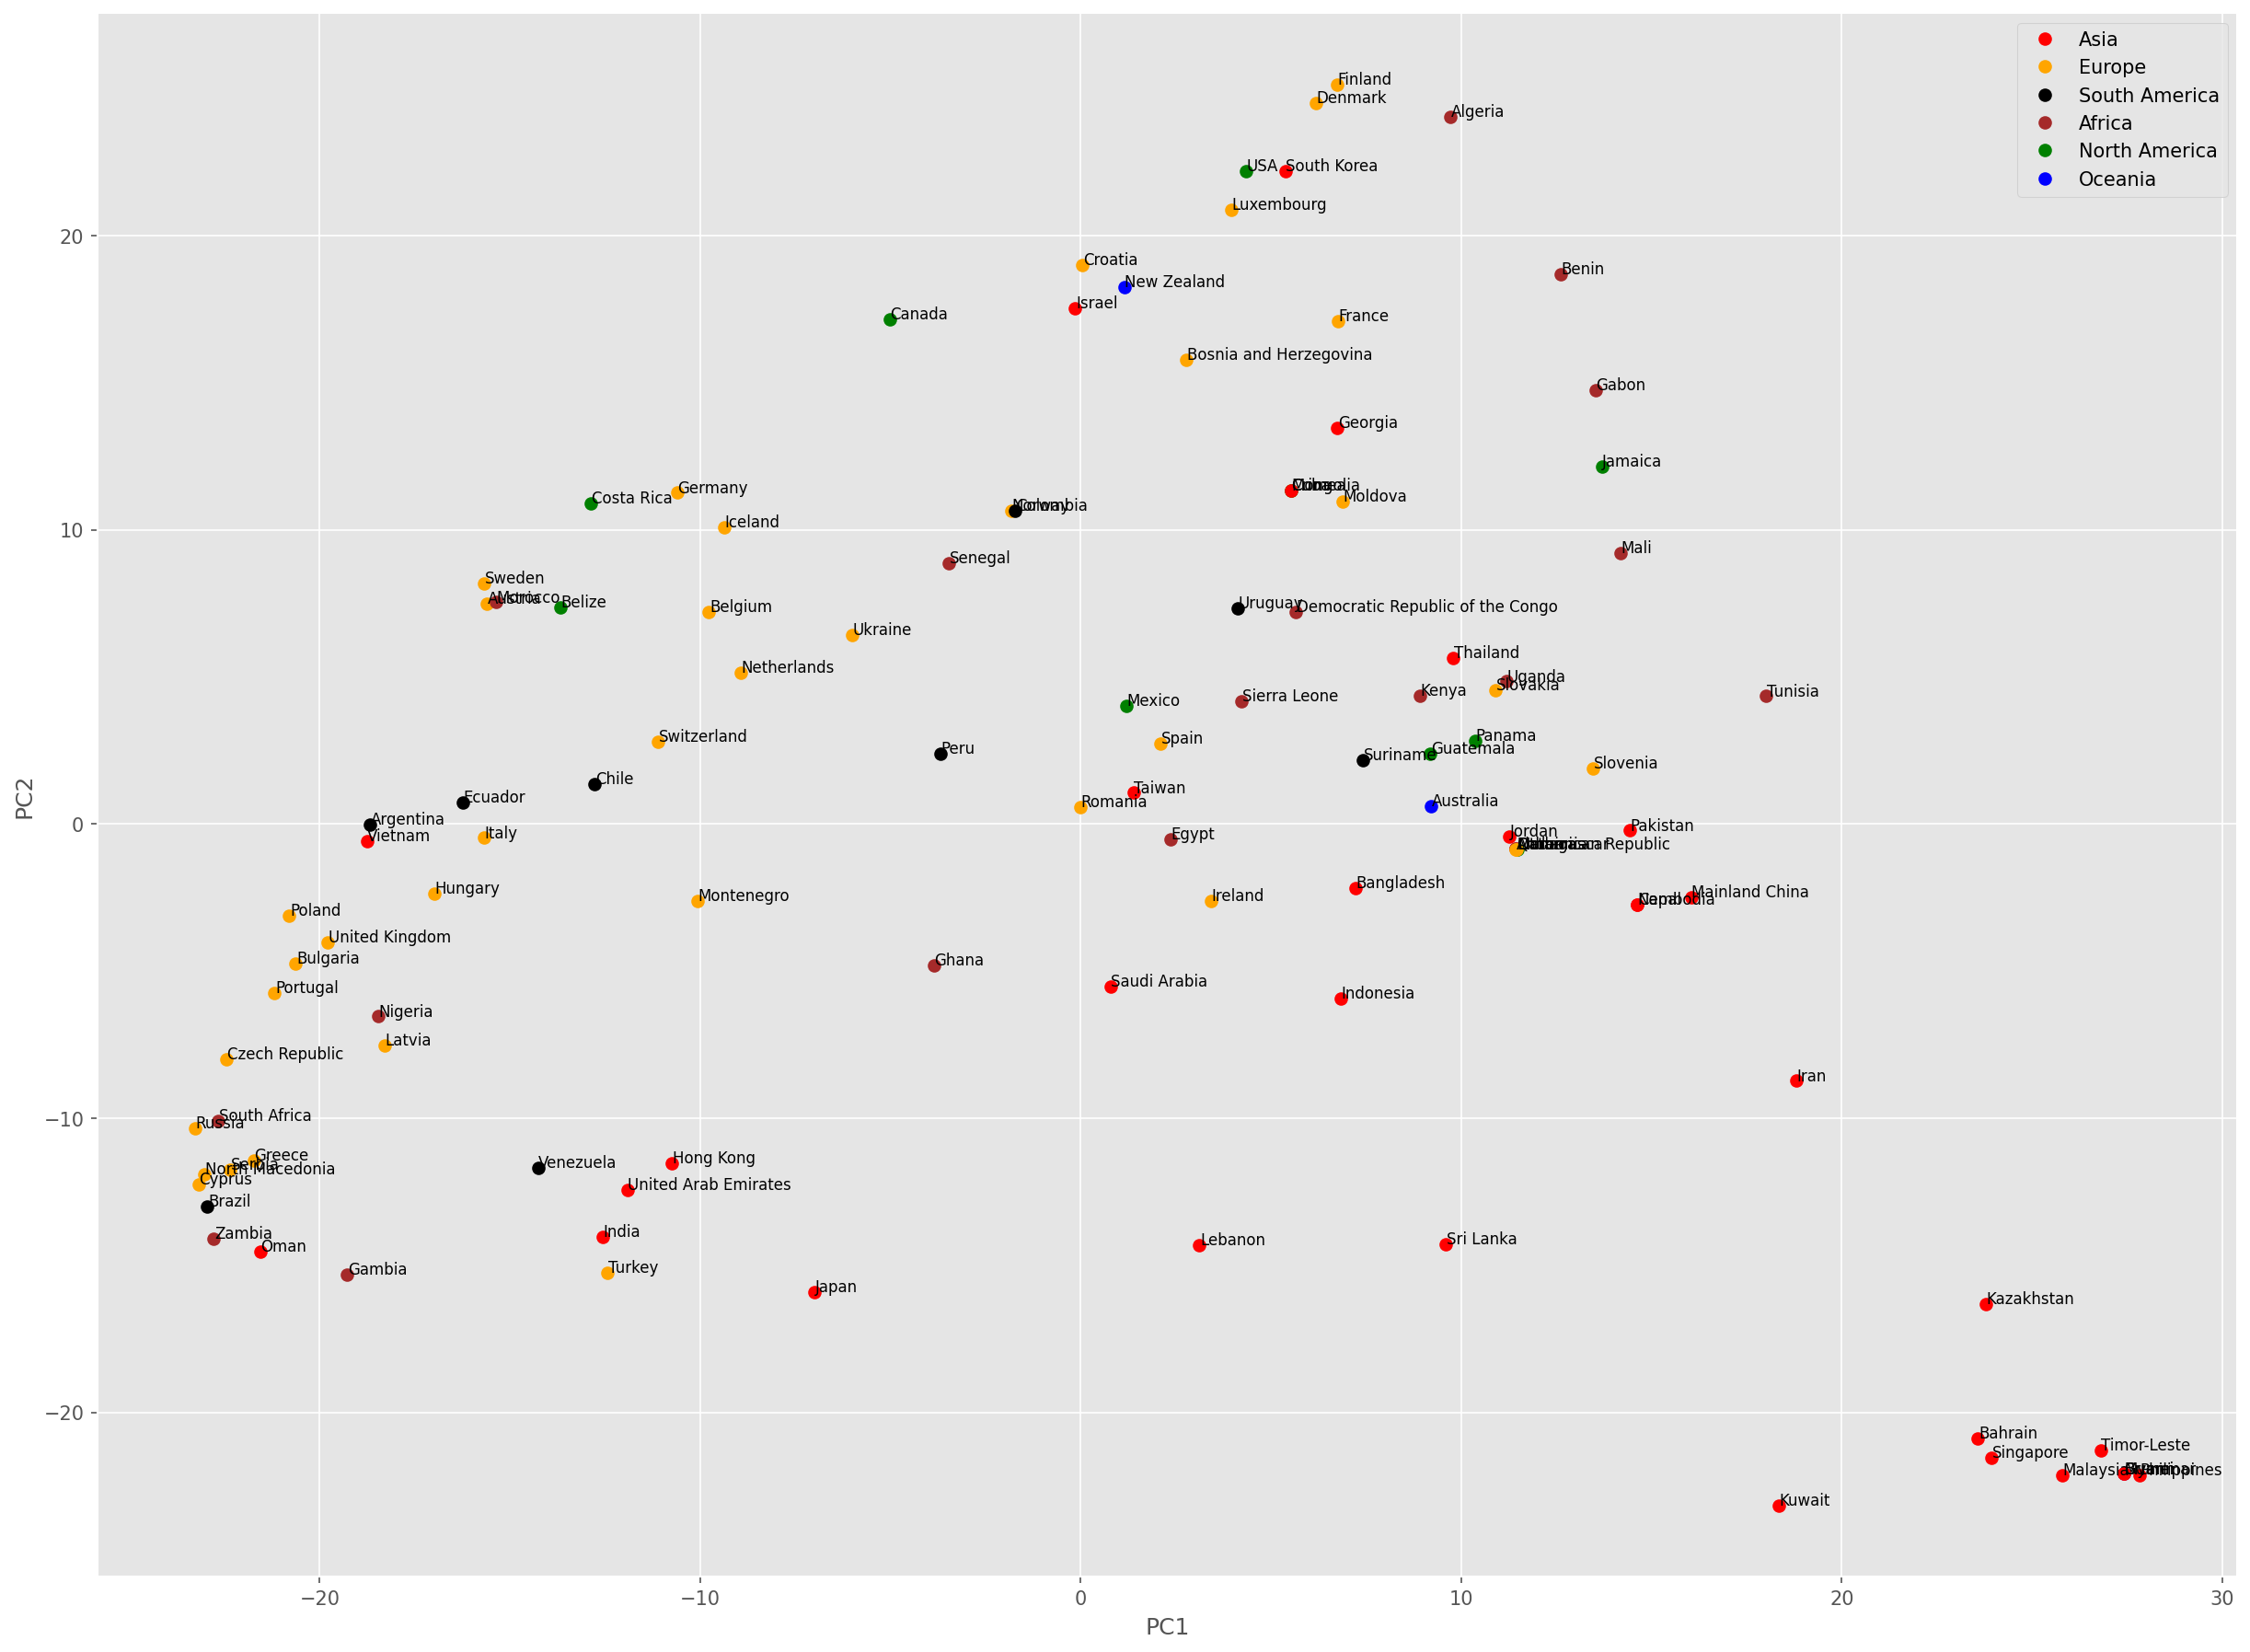

In [33]:
DPI = 150
fig = plt.figure(figsize=(20, 15), dpi=DPI)   
n_row = X_2d.shape[0]
seen = set([])
for i, country in enumerate(filt_country_vs_continent):
#     continent = country_to_continent[idx_to_region[i][0]]
    continent = filt_country_vs_continent[country]
    if continent in seen:
        plt.plot(X_2d[i, 0], X_2d[i, 1], 'o', color=continent_vs_color[continent])
        
    else:
        plt.plot(X_2d[i, 0], X_2d[i, 1], 'o', color=continent_vs_color[continent], label=continent)
        seen.add(continent)
    plt.text(X_2d[i, 0] + 0.015, X_2d[i, 1] + 0.015, country, size=8)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('all_data_ism_pca.png', bbox_inches='tight')
plt.show()

In [34]:
pca_data = []
for month in range(1,10):
    start_date = pd.to_datetime(f'2020-{month}-01', format='%Y-%m-%d')
    end_date = pd.to_datetime(f'2020-{month+1}-01', format='%Y-%m-%d')
    mask = (ism_df['date'] >= start_date) & (ism_df['date'] < end_date)
    data_df = ism_df.loc[mask]
    X_2d, fig = ism_pca(data_df)
    pca_data.append(X_2d)
    fig.savefig(f"2020-{month}-01 to 2020-{month}-{start_date.days_in_month}_ism_pca.png", bbox_inches='tight')
    plt.close(fig)

In [35]:
from sklearn.cluster import KMeans
kmeans0 = KMeans(n_clusters=5, random_state=0)
kmeans0.fit(pca_data[0])
center0 = kmeans0.cluster_centers_.copy()

kmeans1 = KMeans(n_clusters=5, random_state=0)
kmeans1.fit(pca_data[1])
center1 = kmeans1.cluster_centers_.copy()

In [36]:
n_clusters = 5
cluster_idx_list = np.arange(n_clusters)

first_centers = None

dist_to_first = np.zeros((n_clusters, n_clusters))
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

for i in range(len(pca_data)):
    kmeans.fit(pca_data[i])
    y_kmeans = kmeans.predict(pca_data[i])

    fig = plt.figure(figsize=(20, 15))

    centers_ = kmeans.cluster_centers_
    idxes_ = cluster_idx_list

    if first_centers is None:
        first_centers = kmeans.cluster_centers_
    # else:
    #     for i, center in enumerate(centers):
    #         dist_to_first[]
    
    # temp = sorted(zip(cluster_idx_list, kmeans.cluster_centers_, norm_dist_centers), key=lambda tup: tup[2])
    # sorted_idx, sorted_centers, _ = map(list, zip(*temp))
    # sorted_idx = np.array(sorted_idx)
    # sorted_centers = np.array(sorted_centers)

    plt.scatter(pca_data[i][:, 0], pca_data[i][:, 1], c=idxes_[y_kmeans], s=50, cmap='viridis')

    plt.scatter(centers_[:, 0], centers_[:, 1], s=200, c=idxes_, alpha=0.8, edgecolors='black')

    for j, country in enumerate(filt_country_vs_continent):
        plt.text(pca_data[i][j, 0] + 0.015, pca_data[i][j, 1] + 0.015, country, size=8)

IndexError: index 22 is out of bounds for axis 0 with size 22

In [39]:
pca_data[0].shape

(22, 2)